In [1]:
import pandas as pd
import numpy as np
import json
import os
import operator

import matplotlib.pyplot as plt
import seaborn as sns

import evaluate_queries as evaluate_queries

from pathlib import Path

from sklearn.metrics import ndcg_score
from tqdm import tqdm

sns.set(rc={'figure.figsize':(19, 11)}, font_scale=2)

# Distribution of Wikipage categories in the dataset

In [2]:
wikipage_to_categories_path = '../../data/queries/wikipages/groundtruth_generation/wikipage_to_categories.json'
category_to_num_occurrences_path='../../data/queries/wikipages/groundtruth_generation/category_to_num_occurrences.json'
wikipage_relevance_scores_path='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/jaccard/'
filtered_queries_df_path='../../data/tables/wikipages/wikipages_filtered_df.pickle'

with open(wikipage_to_categories_path) as fp:
    wikipage_to_categories = json.load(fp)
with open(category_to_num_occurrences_path) as fp:
    category_to_num_occurrences = json.load(fp)

In [3]:
# Extract into a list the number of categories for each wikipage
num_categories_per_wikipage_list = [len(wikipage_to_categories[wikipage]) for wikipage in wikipage_to_categories]

# Extract into a list the number of wikipages a category appears in
num_wikipages_per_category_list = list(category_to_num_occurrences.values())

# Extract into a list the number of relevant wikipages for each query
num_relevant_wikipages_per_wikipage_list = []
queries_wikipage_ids = set(pd.read_pickle(filtered_queries_df_path)['wikipage_id'])
for file in sorted(os.listdir(wikipage_relevance_scores_path)):
    wikipage_id = int(file.split('.')[0])
    if wikipage_id in queries_wikipage_ids:
        with open(wikipage_relevance_scores_path+file, 'r') as fp:
            relevance_dict = json.load(fp)
        num_relevant_wikipages_per_wikipage_list.append(len(relevance_dict))

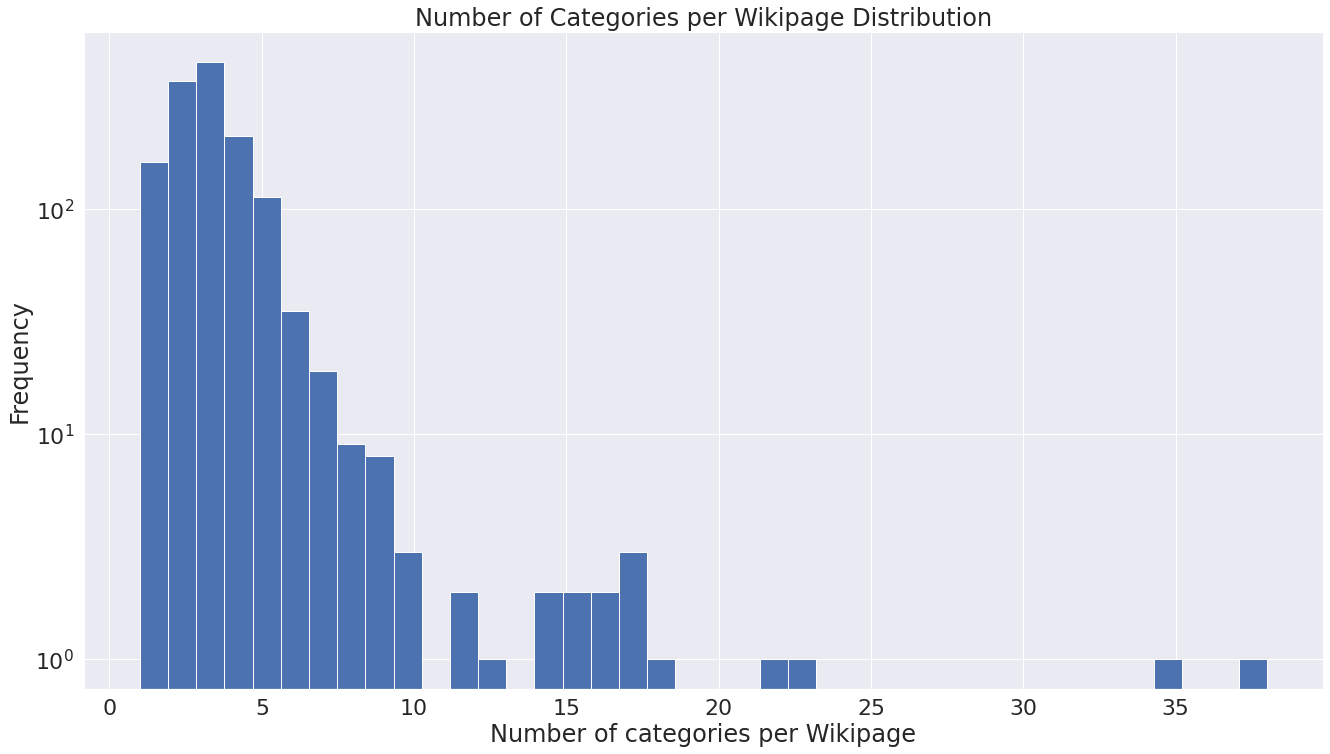

In [4]:
ax = plt.hist(num_categories_per_wikipage_list, bins=40)
plt.yscale('log');plt.xlabel("Number of categories per Wikipage");plt.ylabel('Frequency');plt.title('Number of Categories per Wikipage Distribution');plt.tight_layout()
plt.savefig('figures/wikipage_categories/num_categories_per_wikipage.svg')

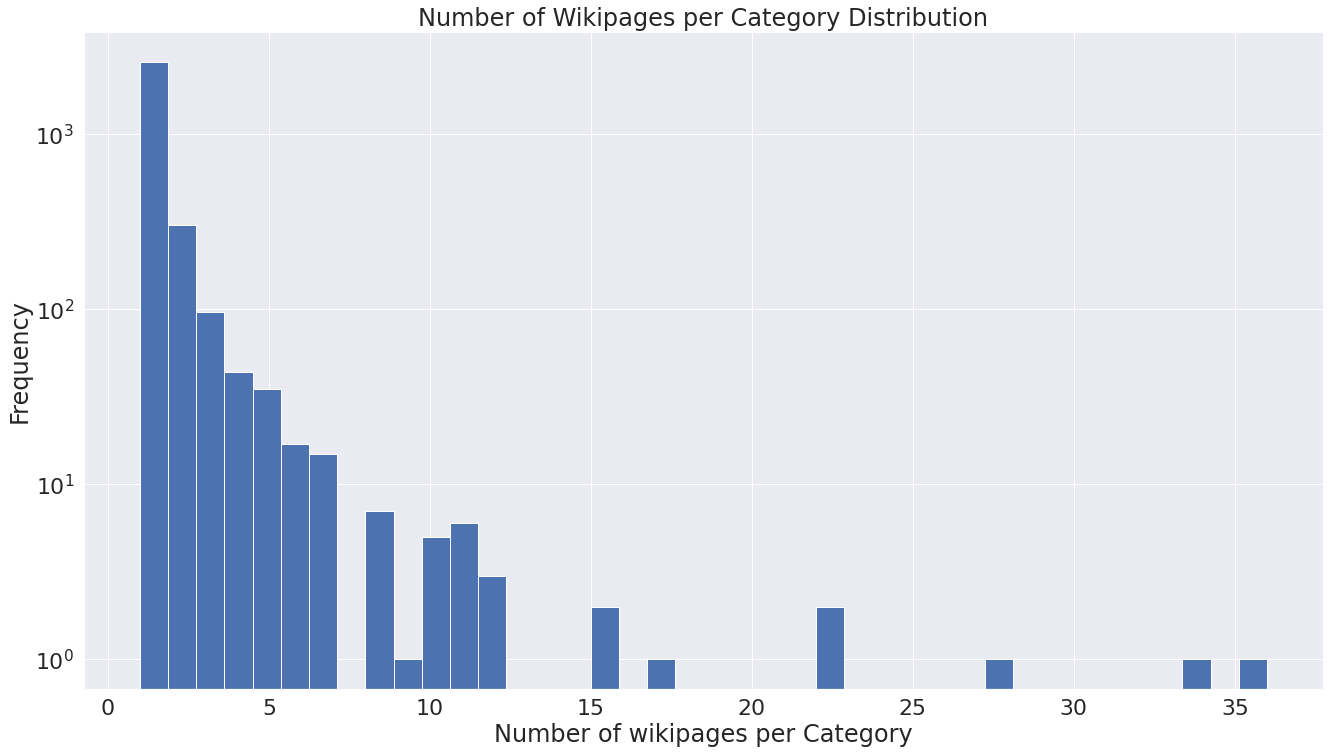

In [5]:
ax = plt.hist(num_wikipages_per_category_list, bins=40)
plt.yscale('log');plt.xlabel("Number of wikipages per Category");plt.ylabel('Frequency');plt.title('Number of Wikipages per Category Distribution');plt.tight_layout()
plt.savefig('figures/wikipage_categories/num_wikipages_per_category.svg')

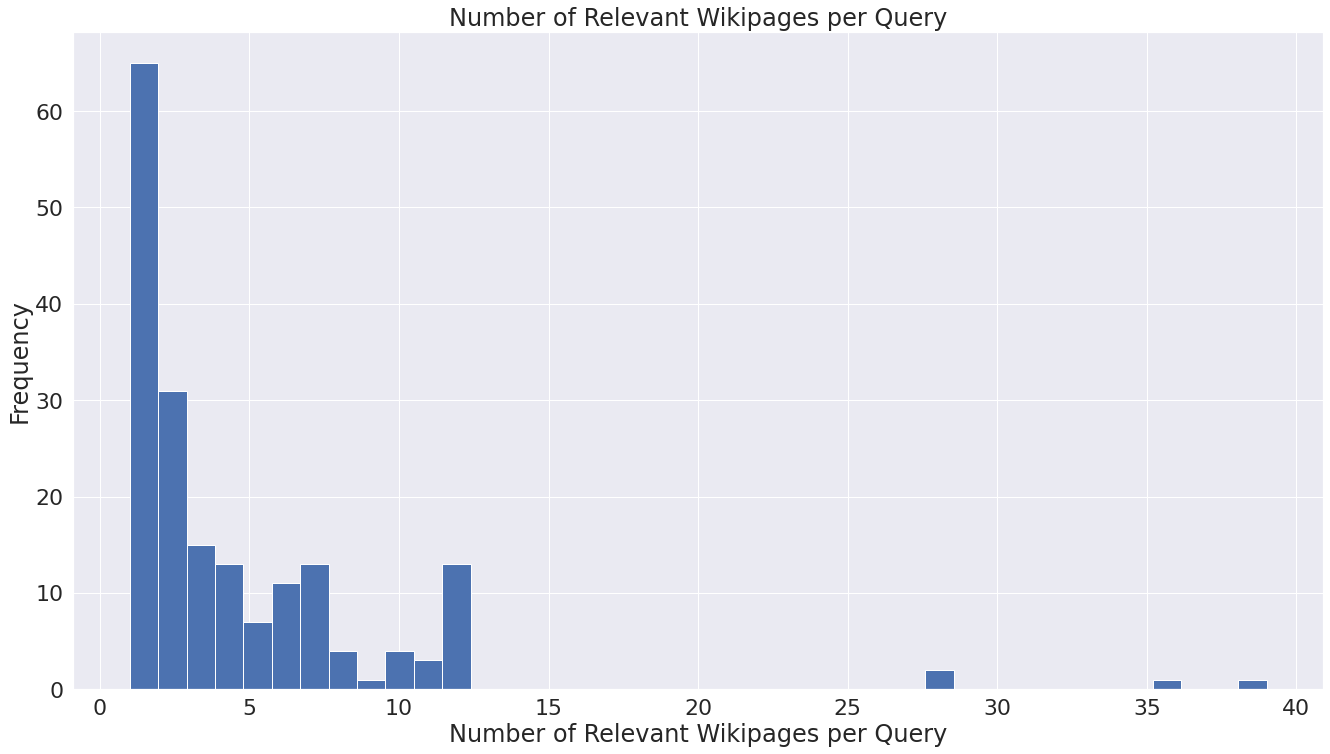

In [6]:
ax = plt.hist(num_relevant_wikipages_per_wikipage_list, bins=40)
plt.xlabel("Number of Relevant Wikipages per Query");plt.ylabel('Frequency');plt.title('Number of Relevant Wikipages per Query');plt.tight_layout()
plt.savefig('figures/wikipage_categories/num_relevant_wikipages_per_query.svg')

# Evaluation using Wikipage Categories (Brute Force Search)

In [7]:
def update_df(df, scores_path):
    '''
    Given a wikipages queries dataframe `df` and its respective NDCG `scores_path`
    update df to map the NDCG scores @k for each wikipage
    '''
    for file in os.listdir(scores_path):
        with open(scores_path + file, 'r') as f:
            scores_dict = json.load(f)

        wikipage_id_to_score = {}
        for wikipage_id in scores_dict:
            wikipage_id_to_score[int(wikipage_id)] = scores_dict[wikipage_id]['ndcg']
        
        k = file.split('_')[-1].split('.')[0]
        df['ndcg@'+k] = np.nan
        df['ndcg@'+k] = df['wikipage_id'].map(wikipage_id_to_score)

    return df

def get_query_df_dict(query_df_base_dir, score_paths_base_dir, min_tuple_width, mode, tuples_per_query_list):
    # Dictionary keyed by the number of tuples per query to the query dataframe that contains the NDCG scores at various k values
    query_df_dict = {}

    for tuples_per_query in tuples_per_query_list:
        df = pd.read_pickle(query_df_base_dir+'minTupleWidth_2_tuplesPerQuery_'+str(tuples_per_query)+'.pickle')  
        scores_path = score_paths_base_dir + 'minTupleWidth_' + str(min_tuple_width) + '_tuplesPerQuery_' + str(tuples_per_query) + '/' + mode + '/'

        query_df_dict[tuples_per_query] = update_df(df, scores_path)
    
    return query_df_dict

def get_mean_ndcg_scores_at_k(df_dict, top_k_vals, tuples_per_query_list):
    mean_ndcg_scores_at_k = {}
    for tuples_per_query in tuples_per_query_list:
        mean_ndcg_scores_at_k[tuples_per_query] = [df_dict[tuples_per_query]['ndcg@'+str(k)].mean() for k in top_k_vals]
    return mean_ndcg_scores_at_k

In [8]:
query_df_base_dir = '../../data/queries/wikipages/query_dataframes/'
score_paths_base_dir = 'eval_over_search_output/wikipage_categories_relevant/'
min_tuple_width=2
tuples_per_query_list = [1, 2, 5, 10, 15, 20]

# Updated Dataframes for Wikipages with Categories (Jaccard)
query_df_categories_jaccard = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=score_paths_base_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard',
    tuples_per_query_list=tuples_per_query_list
)

# Updated Dataframes for Wikipages with Categories (Jaccard)
query_df_categories_weighted = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=score_paths_base_dir,
    min_tuple_width=min_tuple_width,
    mode = 'weighted',
    tuples_per_query_list=tuples_per_query_list
)

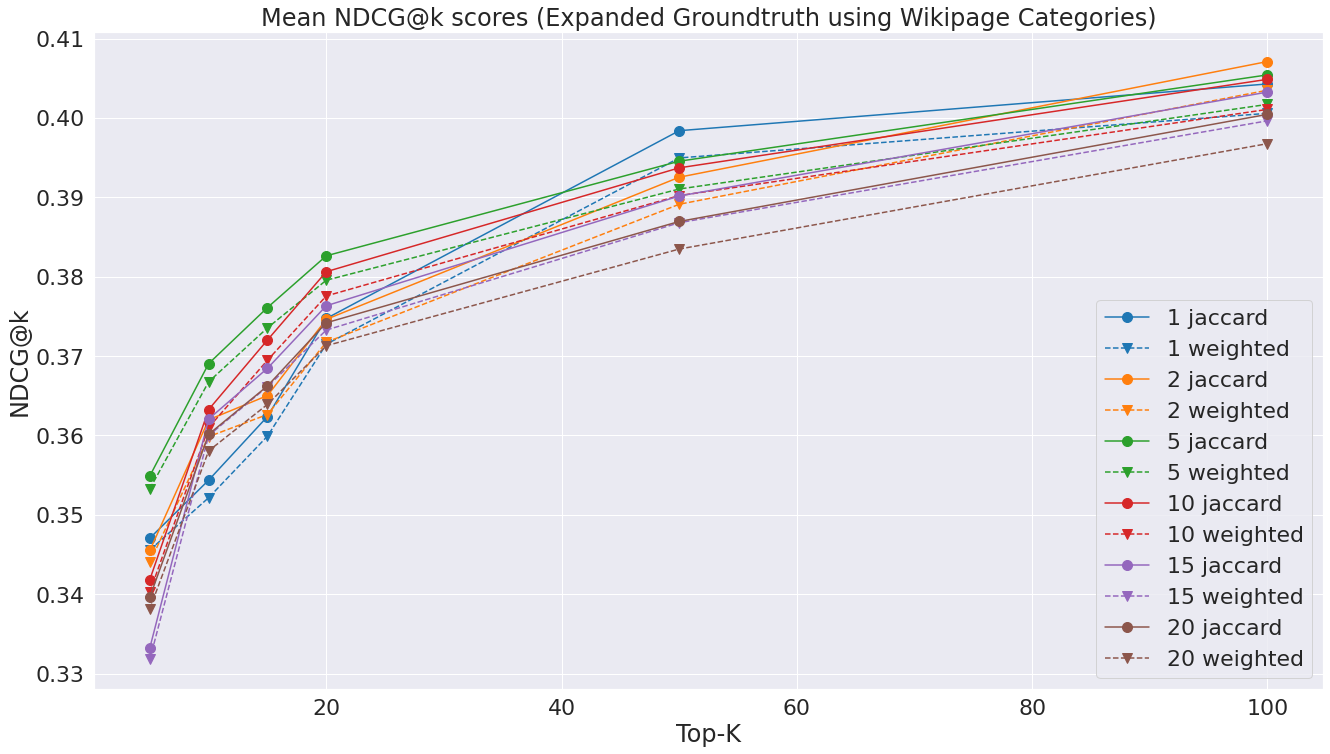

In [9]:
top_k_vals = [5,10,15,20,50,100]

# Get dictionaries keyed by the tuples per query mapping to a list of the NDCG scores at the specified top-k
mean_ndcg_scores_at_k_categories_jaccard = get_mean_ndcg_scores_at_k(query_df_categories_jaccard, top_k_vals, tuples_per_query_list)
mean_ndcg_scores_at_k_categories_weighted = get_mean_ndcg_scores_at_k(query_df_categories_weighted, top_k_vals, tuples_per_query_list)


colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories_jaccard[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' jaccard')

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories_weighted[tuples_per_query_list[i]], linestyle='dashed',
        marker='v', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' weighted')

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (Expanded Groundtruth using Wikipage Categories)');plt.legend();plt.tight_layout()
plt.savefig('figures/wikipage_categories/topk_ndcg@k_brute_force.svg')

# Evaluating using Wikipage Categories (BM25)

In [10]:
def get_ndcg_scores_bm25(df, full_df, scores_df, k=10, groundtruth_relevance_scores_dir=None):
    wikipage_id_to_ndcg_score = {}

    for wikipage_id in scores_df['wikipage_id'].unique():
        cur_df = scores_df[scores_df['wikipage_id']==wikipage_id]

        # Get the ground truth relevance scores
        gt_tables_to_relevance_scores_dict = evaluate_queries.get_gt_tables_to_relevance_scores_dict(
            df, full_df, wikipage_id, groundtruth_relevance_scores_dir
        )
        # gt_relevant_tables = set(df[df['wikipage_id']==wikipage_id]['tables'].values[0])

        top_k_tables = cur_df['table_id'].values

        # Get top-k tables and their scores
        if len(top_k_tables) >= k:
            top_k_tables = top_k_tables[:k]

            # Construct groundtruth relevance scores
            gt_relevance = []
            for table in top_k_tables:
                if table in gt_tables_to_relevance_scores_dict.keys():
                    gt_relevance.append(gt_tables_to_relevance_scores_dict[table])
                else:
                    gt_relevance.append(0)

            gt_relevance = np.array([gt_relevance])
            predicted_relevance = np.array([cur_df['score'].values[:k]])

            score = ndcg_score(gt_relevance, predicted_relevance)
            wikipage_id_to_ndcg_score[int(wikipage_id)] = score

    return wikipage_id_to_ndcg_score

def get_updated_df(df, full_df, scores_path, k_vals, groundtruth_relevance_scores_dir=None):
    scores_df = pd.read_csv(scores_path, sep="\t", index_col=False, names=["wikipage_id", "query", "table_id", "rank", "score", "field"])

    for k in k_vals:
        wikipage_id_to_ndcg_score = get_ndcg_scores_bm25(
            df=df, full_df=full_df, scores_df=scores_df,
            k=k, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir)
        df['ndcg@'+str(k)] = np.nan
        df['ndcg@'+str(k)] = df['wikipage_id'].map(wikipage_id_to_ndcg_score)
    return df

In [11]:
full_df_path="../../data/queries/wikipages/query_dataframes/minTupleWidth_all_tuplesPerQuery_all.pickle"
full_df = pd.read_pickle(full_df_path)
groundtruth_relevance_scores_dir_jaccard='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/jaccard/'
groundtruth_relevance_scores_dir_weighted='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/weighted/'

In [12]:
def get_ndcg_scores_bm25_new(df, full_df, scores_df, k=10, groundtruth_relevance_scores_dir=None):
    wikipage_id_to_ndcg_score = {}

    for wikipage_id in scores_df['wikipage_id'].unique():
        cur_df = scores_df[scores_df['wikipage_id']==wikipage_id]

        total_num_tables=20000

        # Get the ground truth relevance scores
        gt_tables_to_relevance_scores_dict = evaluate_queries.get_gt_tables_to_relevance_scores_dict(
            df, full_df, wikipage_id, groundtruth_relevance_scores_dir
        )

        top_k_tables = set(cur_df['table_id'].values)
        print(top_k_tables)

        # Construct the gt_relevance and predicted_relevance 

        break

        # Get top-k tables and their scores
        if len(top_k_tables) >= k:
            top_k_tables = top_k_tables[:k]

            # Construct groundtruth relevance scores
            gt_relevance = []
            for table in top_k_tables:
                if table in gt_tables_to_relevance_scores_dict.keys():
                    gt_relevance.append(gt_tables_to_relevance_scores_dict[table])
                else:
                    gt_relevance.append(0)

            gt_relevance = np.array([gt_relevance])
            predicted_relevance = np.array([cur_df['score'].values[:k]])

            score = ndcg_score(gt_relevance, predicted_relevance)
            wikipage_id_to_ndcg_score[int(wikipage_id)] = score

    return wikipage_id_to_ndcg_score

def get_updated_df_new(df, full_df, scores_path, k_vals, groundtruth_relevance_scores_dir=None):
    scores_df = pd.read_csv(scores_path, sep="\t", index_col=False, names=["wikipage_id", "query", "table_id", "rank", "score", "field"])

    for k in k_vals:
        wikipage_id_to_ndcg_score = get_ndcg_scores_bm25_new(
            df=df, full_df=full_df, scores_df=scores_df,
            k=k, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir)
        df['ndcg@'+str(k)] = np.nan
        df['ndcg@'+str(k)] = df['wikipage_id'].map(wikipage_id_to_ndcg_score)

        break
    return df

In [13]:
tmp_df = pd.read_pickle('../../data/queries/wikipages/query_dataframes/minTupleWidth_2_tuplesPerQuery_10.pickle')
df_content_text_jaccard = get_updated_df_new(df=tmp_df.copy(), full_df=full_df, scores_path='../../Web-Table-Retrieval-Benchmark/data/wikipages/ranking/minTupleWidth_2_tuplesPerQuery_10/entities/content.txt',
    k_vals=top_k_vals, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_jaccard)
df_content_text_jaccard

{'table-0317-844.json', 'table-0679-934.json', 'table-0493-126.json', 'table-0724-518.json', 'table-0317-848.json', 'table-0557-585.json', 'table-1286-987.json', 'table-1286-989.json', 'table-0493-111.json', 'table-0679-931.json', 'table-0931-205.json', 'table-1384-720.json', 'table-0493-129.json', 'table-0199-316.json', 'table-0493-115.json', 'table-0410-718.json', 'table-0199-321.json', 'table-0679-901.json', 'table-0493-124.json', 'table-0493-130.json', 'table-0199-314.json', 'table-0679-902.json', 'table-0557-573.json', 'table-0199-330.json', 'table-0091-57.json', 'table-0679-893.json', 'table-0493-132.json', 'table-0679-936.json', 'table-1384-714.json', 'table-0493-114.json', 'table-0679-932.json', 'table-0493-118.json', 'table-0199-332.json', 'table-0199-331.json', 'table-1369-617.json', 'table-0317-841.json', 'table-0679-895.json', 'table-0199-324.json', 'table-0317-847.json', 'table-0199-328.json', 'table-0679-938.json', 'table-0317-846.json', 'table-0199-322.json', 'table-1339

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@5
344,https://en.wikipedia.org/wiki/List_of_vaudevil...,344,10,"[table-0002-885.json, table-0002-886.json, tab...","[53, 32, 105, 66, 50, 18, 41, 44, 61, 11]",2.0,10.0,table-0002-887.json,"[3, 7, 9, 13, 14, 15, 18, 20, 21, 22]",0.000000,NaN
2735,https://en.wikipedia.org/wiki/List_of_Paramoun...,2735,12,"[table-0017-696.json, table-0017-697.json, tab...","[21, 129, 52, 19, 22, 20, 89, 79, 108, 80, 83,...",2.0,10.0,table-0017-697.json,"[2, 4, 6, 7, 9, 10, 11, 12, 14, 17]",0.045455,NaN
3381,https://en.wikipedia.org/wiki/Los_Angeles_Lake...,3381,16,"[table-0022-127.json, table-0022-128.json, tab...","[25, 28, 23, 64, 26, 43, 51, 24, 33, 58, 52, 2...",3.0,10.0,table-0022-130.json,"[0, 1, 2, 3, 4, 8, 9, 10, 11, 12]",0.092063,NaN
5740,https://en.wikipedia.org/wiki/2007_IIHF_World_...,5740,16,"[table-0038-375.json, table-0038-377.json, tab...","[24, 21, 30, 22, 26, 20, 22, 34, 18, 12, 28, 1...",2.0,10.0,table-0038-390.json,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10]",0.040741,NaN
5846,https://en.wikipedia.org/wiki/List_of_Roman_co...,5846,12,"[table-0039-315.json, table-0039-316.json, tab...","[13, 78, 62, 26, 31, 23, 53, 75, 121, 113, 76,...",2.0,10.0,table-0039-316.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0.040404,NaN
...,...,...,...,...,...,...,...,...,...,...,...
235493,https://en.wikipedia.org/wiki/List_of_sportspe...,235493,11,"[table-1597-523.json, table-1597-524.json, tab...","[96, 22, 53, 29, 88, 201, 192, 30, 36, 137, 36]",4.0,10.0,table-1597-533.json,"[1, 2, 8, 13, 19, 23, 27, 32, 33, 34]",0.015152,NaN
236836,https://en.wikipedia.org/wiki/List_of_doping_c...,236836,24,"[table-1606-361.json, table-1606-362.json, tab...","[99, 31, 88, 65, 119, 45, 28, 68, 74, 123, 91,...",3.0,10.0,table-1606-361.json,"[0, 1, 10, 16, 20, 28, 34, 35, 43, 52]",0.183230,NaN
239032,https://en.wikipedia.org/wiki/Missouri's_8th_c...,239032,11,"[table-1620-704.json, table-1620-705.json, tab...","[24, 28, 122, 26, 28, 28, 30, 28, 28, 18, 28]",2.0,10.0,table-1620-706.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0.438889,NaN
239349,https://en.wikipedia.org/wiki/List_of_Internat...,239349,10,"[table-1622-662.json, table-1622-663.json, tab...","[21, 17, 17, 12, 10, 24, 16, 13, 20, 25]",5.0,10.0,table-1622-676.json,"[3, 5, 6, 9, 10, 11, 12, 14, 15, 16]",0.144444,NaN


In [14]:
min_tuple_width=2
bm25_scores_base_path='../../Web-Table-Retrieval-Benchmark/data/wikipages/ranking/'
query_dfs_path='../../data/queries/wikipages/query_dataframes/'
tuples_per_query_list = [1, 2, 5, 10, 15, 20]
top_k_vals = [5,10,15,20,50,100]

# Dictionary keyed by tuples per query and maps to another dictionary keyed by 'entities' and 'text'
# which in turn map to a dictionary keyed by 'catchall', 'content', etc. and map to their respective dataframes with NDCG scores
dfs_dict = {}

for tuples_per_query in tqdm(tuples_per_query_list):
    base_num_tuples_path='minTupleWidth_' + str(min_tuple_width) + '_tuplesPerQuery_'+str(tuples_per_query)
    bm25_scores_path_entities = bm25_scores_base_path+base_num_tuples_path+'/entities/'
    bm25_scores_path_text = bm25_scores_base_path+base_num_tuples_path+'/text/'

    # Read the query dataframe
    df = pd.read_pickle(query_dfs_path + base_num_tuples_path+'.pickle')

    # Construct the modified dataframes with the NDCG scores
    df_content_text_jaccard = get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_text+'content.txt',
        k_vals=top_k_vals, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_jaccard)
    df_content_text_weighted = get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_text+'content.txt',
        k_vals=top_k_vals, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_weighted)

    df_content_entities_jaccard = get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_entities+'content.txt',
        k_vals=top_k_vals, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_jaccard)
    df_content_entities_weighted = get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_entities+'content.txt',
        k_vals=top_k_vals, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_weighted)

    # Update dfs_dict
    dfs_dict[tuples_per_query] = {}
    dfs_dict[tuples_per_query]['entities'] = {'content_jaccard': df_content_entities_jaccard, 'content_weighted': df_content_entities_weighted}
    dfs_dict[tuples_per_query]['text'] = {'content_jaccard': df_content_text_jaccard,'content_weighted': df_content_text_weighted} 

100%|██████████| 6/6 [01:44<00:00, 17.37s/it]


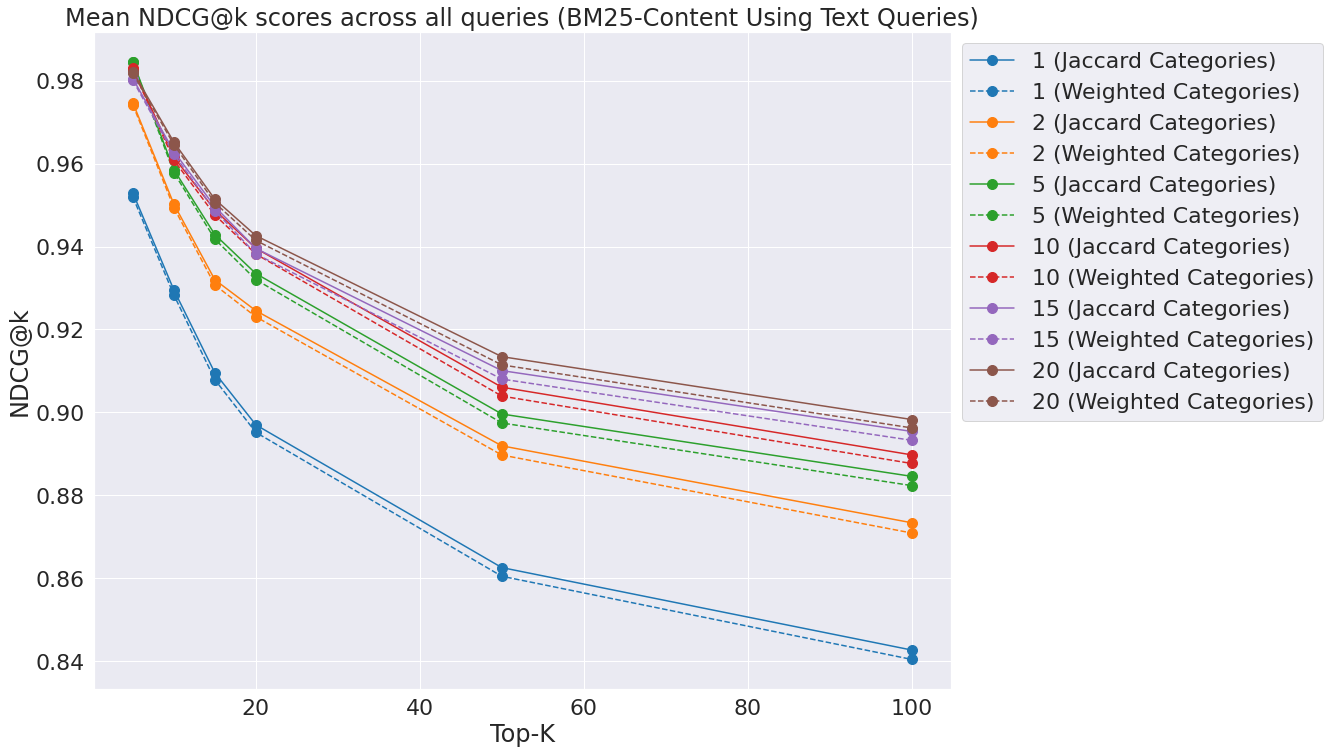

In [15]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    mean_ndcg_scores_at_k_jaccard = [dfs_dict[tuples_per_query_list[i]]['text']['content_jaccard']['ndcg@'+str(k)].mean() for k in top_k_vals]
    mean_ndcg_scores_at_k_weighted = [dfs_dict[tuples_per_query_list[i]]['text']['content_weighted']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_jaccard, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Jaccard Categories)', color=colors[i])
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_weighted, '--', marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Weighted Categories)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores across all queries (BM25-Content Using Text Queries)');plt.tight_layout()
plt.savefig('figures/wikipage_categories/bm25_content_text_queries.svg')

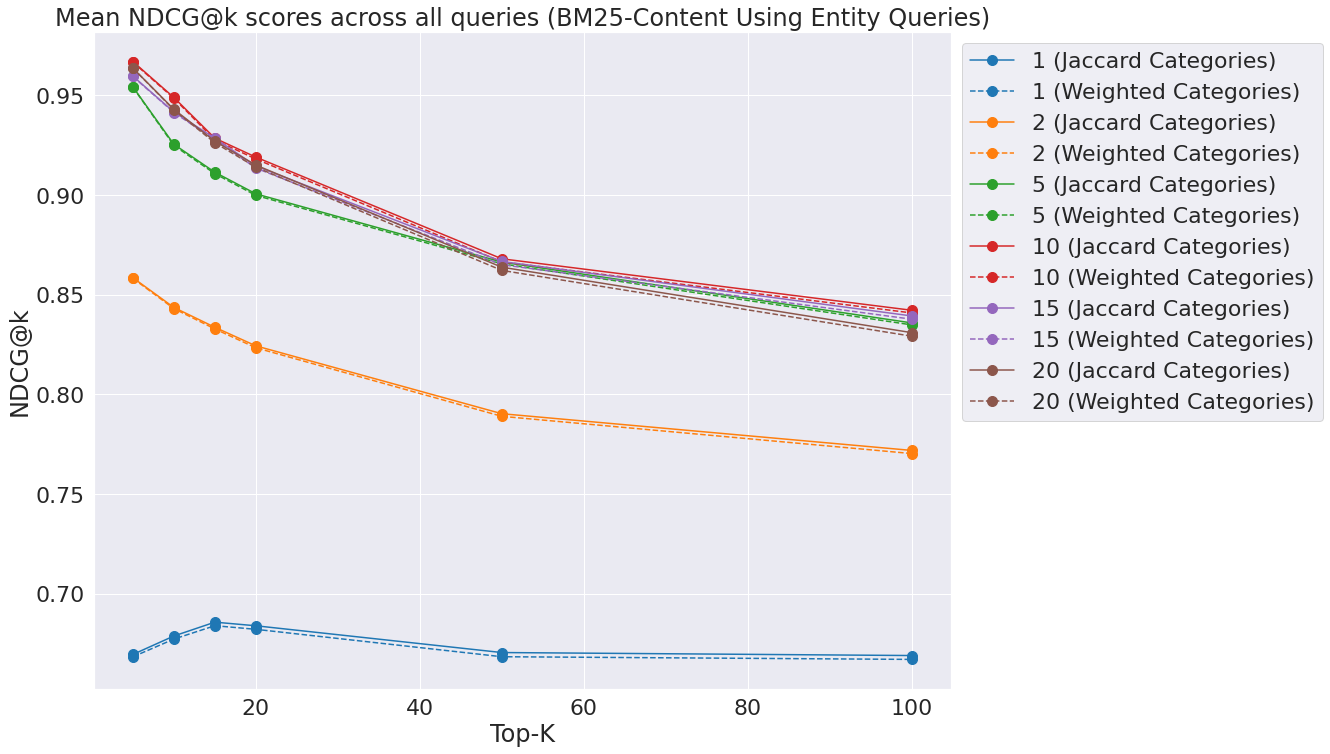

In [16]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    mean_ndcg_scores_at_k_jaccard = [dfs_dict[tuples_per_query_list[i]]['entities']['content_jaccard']['ndcg@'+str(k)].mean() for k in top_k_vals]
    mean_ndcg_scores_at_k_weighted = [dfs_dict[tuples_per_query_list[i]]['entities']['content_weighted']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_jaccard, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Jaccard Categories)', color=colors[i])
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_weighted, '--', marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Weighted Categories)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores across all queries (BM25-Content Using Entity Queries)');plt.tight_layout()
plt.savefig('figures/wikipage_categories/bm25_content_entity_queries.svg')

# Query Results Exploration

## Brute Force Jaccard (10 tuples per query and NDCG@k=10)

In [19]:
def get_exploration_summary(wikipage_id, queries_dir, search_output_dir, groundtruth_relevance_scores_dir):

    with open(queries_dir + 'wikipage_' + str(wikipage_id) + '.json') as fp:
        query = json.load(fp)['queries']
    print("Query:\n", query)

    with open(search_output_dir + 'wikipage_' + str(wikipage_id) + '/search_output/filenameToScore.json') as fp:
        scores = json.load(fp)['scores']
    print("\nWikipage titles of top scored tables:\n", [table['pgTitle'] for table in scores[:10]])

    with open(groundtruth_relevance_scores_dir + str(wikipage_id) + '.json') as fp:
        wikipage_relevance_scores = json.load(fp)
    print("\nGroundtruth Wikipages relevance scores:\n", wikipage_relevance_scores)

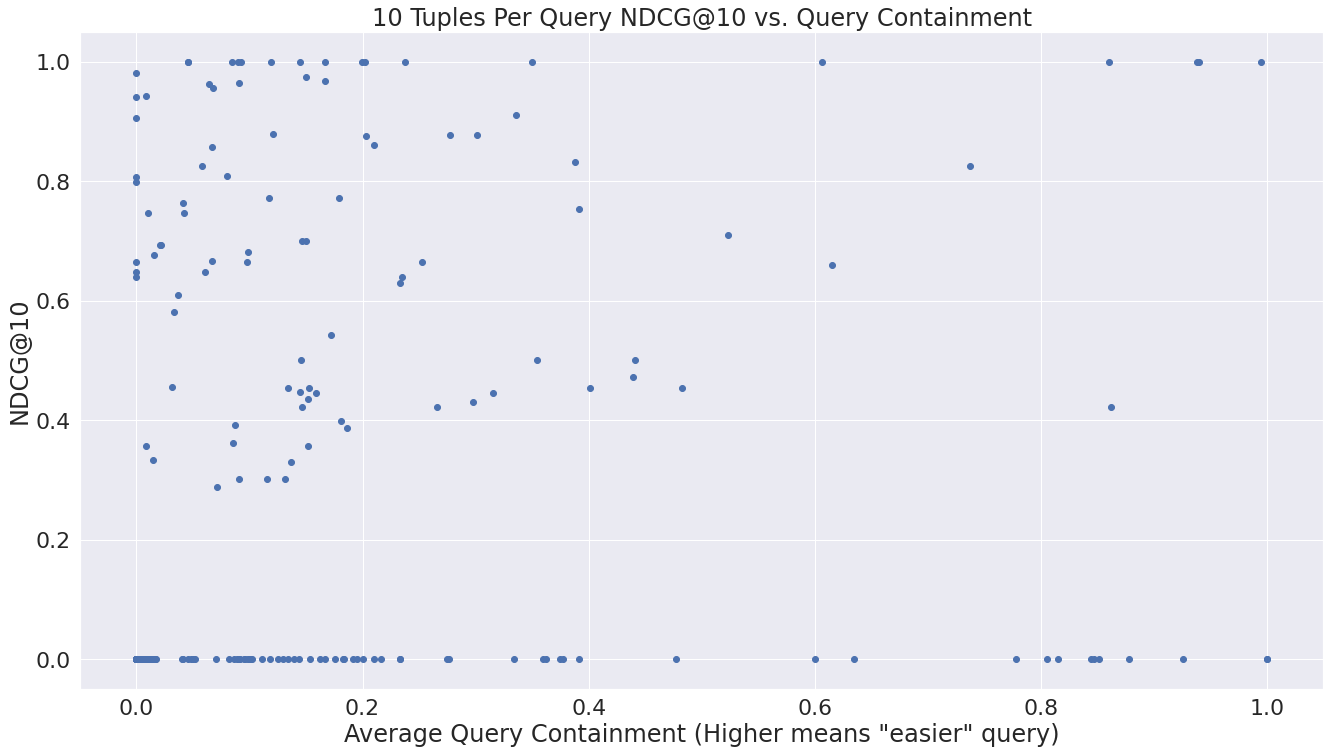

In [20]:
plt.scatter(query_df_categories_jaccard[10]['avg_query_containment'], query_df_categories_jaccard[10]['ndcg@10'])
plt.xlabel('Average Query Containment (Higher means "easier" query)');plt.ylabel('NDCG@10');plt.title('10 Tuples Per Query NDCG@10 vs. Query Containment');plt.tight_layout()
plt.savefig('figures/wikipage_categories/brute_force_jaccard_ndcg10_vs_query_containment.svg')

In [21]:
queries_dir = '../../data/queries/wikipages/queries/minTupleWidth_2_tuplesPerQuery_10/'
search_output_dir = '../../data/search/wikipages/minTupleWidth_2_tuplesPerQuery_10/jaccard/'
groundtruth_relevance_scores_dir_weighted='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/weighted/'

### Top-Right Corner (Easy Query & High NDCG score)

In [31]:
cur_df = query_df_categories_jaccard[10]
cur_df = cur_df[(cur_df['ndcg@10'] >= 0.8) & (cur_df['avg_query_containment'] >= 0.9)]
wikipage_id = cur_df.iloc[2]['wikipage_id']
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@50,ndcg@100,ndcg@10,ndcg@5,ndcg@200,ndcg@15,ndcg@150,ndcg@20
28503,https://en.wikipedia.org/wiki/World's_busiest_...,28503,11,"[table-0205-825.json, table-0205-826.json, tab...","[56, 58, 58, 56, 56, 56, 57, 57, 57, 57, 58]",2.0,10.0,table-0205-826.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0.940000,0.717198,0.739762,1.0,1.0,0.740340,1.0,0.740195,0.679193
61543,https://en.wikipedia.org/wiki/World's_busiest_...,61543,14,"[table-0422-772.json, table-0422-773.json, tab...","[55, 52, 52, 52, 51, 24, 87, 87, 86, 87, 87, 5...",2.0,10.0,table-0422-781.json,"[1, 2, 5, 6, 7, 8, 9, 11, 12, 13]",0.938462,0.773249,0.781175,1.0,1.0,0.781217,1.0,0.781481,0.925905
148106,https://en.wikipedia.org/wiki/List_of_the_busi...,148106,13,"[table-1012-874.json, table-1012-875.json, tab...","[217, 219, 216, 214, 214, 215, 218, 217, 217, ...",3.0,10.0,table-1012-875.json,"[2, 5, 6, 7, 9, 10, 12, 13, 14, 15]",0.994444,0.986346,0.971208,1.0,1.0,0.954658,1.0,0.966376,1.000000


In [32]:
print("Selected wikipage:", cur_df.iloc[2]['wikipage'], '\n')
get_exploration_summary(wikipage_id, queries_dir, search_output_dir, groundtruth_relevance_scores_dir_weighted)

Selected wikipage: https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_China 

Query:
 [['http://dbpedia.org/resource/Guangzhou_Baiyun_International_Airport', 'http://dbpedia.org/resource/Guangzhou', 'http://dbpedia.org/resource/Guangdong'], ['http://dbpedia.org/resource/Chengdu_Shuangliu_International_Airport', 'http://dbpedia.org/resource/Chengdu', 'http://dbpedia.org/resource/Sichuan'], ['http://dbpedia.org/resource/Kunming_Wujiaba_International_Airport', 'http://dbpedia.org/resource/Kunming', 'http://dbpedia.org/resource/Yunnan'], ['http://dbpedia.org/resource/Haikou_Meilan_International_Airport', 'http://dbpedia.org/resource/Haikou', 'http://dbpedia.org/resource/Hainan'], ['http://dbpedia.org/resource/Hangzhou_Xiaoshan_International_Airport', 'http://dbpedia.org/resource/Hangzhou', 'http://dbpedia.org/resource/Zhejiang'], ['http://dbpedia.org/resource/Xiamen_Gaoqi_International_Airport', 'http://dbpedia.org/resource/Xiamen', 'http://dbpedia.org/resource/Fujian'], ['http:

### Bottom-Right Corner (Easy Query & Low NDCG score)

In [35]:
cur_df = query_df_categories_jaccard[10]
cur_df = cur_df[(cur_df['ndcg@10'] <= 0.2) & (cur_df['avg_query_containment'] >= 0.9)]
wikipage_id = cur_df.iloc[2]['wikipage_id']
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@50,ndcg@100,ndcg@10,ndcg@5,ndcg@200,ndcg@15,ndcg@150,ndcg@20
85987,https://en.wikipedia.org/wiki/List_of_minor_pl...,85987,10,"[table-0579-485.json, table-0579-486.json, tab...","[17, 24, 20, 15, 15, 17, 22, 28, 18, 18]",2.0,10.0,table-0579-490.json,"[0, 1, 2, 5, 7, 10, 11, 12, 13, 15]",0.925926,0.257955,0.209387,0.0,0.0,0.174090,0.0,0.187418,0.0
86072,https://en.wikipedia.org/wiki/List_of_minor_pl...,86072,10,"[table-0580-231.json, table-0580-232.json, tab...","[13, 16, 14, 12, 19, 18, 11, 13, 15, 11]",2.0,10.0,table-0580-241.json,"[0, 3, 4, 7, 8, 11, 16, 17, 22, 23]",1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
179587,https://en.wikipedia.org/wiki/List_of_England_...,179587,10,"[table-1228-884.json, table-1228-885.json, tab...","[40, 43, 24, 13, 23, 28, 33, 34, 33, 32]",2.0,10.0,table-1228-888.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",1.000000,0.000000,0.150190,0.0,0.0,0.293192,0.0,0.182332,0.0


In [36]:
print("Selected wikipage:", cur_df.iloc[2]['wikipage'], '\n')
get_exploration_summary(wikipage_id, queries_dir, search_output_dir, groundtruth_relevance_scores_dir_weighted)

Selected wikipage: https://en.wikipedia.org/wiki/List_of_England_Test_matches 

Query:
 [['http://dbpedia.org/resource/Australia_national_cricket_team', 'http://dbpedia.org/resource/Melbourne_Cricket_Ground'], ['http://dbpedia.org/resource/Australia_national_cricket_team', 'http://dbpedia.org/resource/Melbourne_Cricket_Ground'], ['http://dbpedia.org/resource/Australia_national_cricket_team', 'http://dbpedia.org/resource/Melbourne_Cricket_Ground'], ['http://dbpedia.org/resource/Australia_national_cricket_team', 'http://dbpedia.org/resource/The_Oval'], ['http://dbpedia.org/resource/Australia_national_cricket_team', 'http://dbpedia.org/resource/Melbourne_Cricket_Ground'], ['http://dbpedia.org/resource/Australia_national_cricket_team', 'http://dbpedia.org/resource/Sydney_Cricket_Ground'], ['http://dbpedia.org/resource/Australia_national_cricket_team', 'http://dbpedia.org/resource/Sydney_Cricket_Ground'], ['http://dbpedia.org/resource/Australia_national_cricket_team', 'http://dbpedia.org/re

In [74]:
cur_df = query_df_categories_jaccard[10]
cur_df = cur_df[(cur_df['ndcg@10'] <= 0.2) & (cur_df['avg_query_containment'] >= 0.9)]
wikipage_id = cur_df.iloc[0]['wikipage_id']
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@50,ndcg@100,ndcg@10,ndcg@5,ndcg@200,ndcg@15,ndcg@150,ndcg@20
85987,https://en.wikipedia.org/wiki/List_of_minor_pl...,85987,10,"[table-0579-485.json, table-0579-486.json, tab...","[17, 24, 20, 15, 15, 17, 22, 28, 18, 18]",2.0,10.0,table-0579-490.json,"[0, 1, 2, 5, 7, 10, 11, 12, 13, 15]",0.925926,0.257955,0.209387,0.0,0.0,0.174090,0.0,0.187418,0.0
86072,https://en.wikipedia.org/wiki/List_of_minor_pl...,86072,10,"[table-0580-231.json, table-0580-232.json, tab...","[13, 16, 14, 12, 19, 18, 11, 13, 15, 11]",2.0,10.0,table-0580-241.json,"[0, 3, 4, 7, 8, 11, 16, 17, 22, 23]",1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0
179587,https://en.wikipedia.org/wiki/List_of_England_...,179587,10,"[table-1228-884.json, table-1228-885.json, tab...","[40, 43, 24, 13, 23, 28, 33, 34, 33, 32]",2.0,10.0,table-1228-888.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",1.000000,0.000000,0.150190,0.0,0.0,0.293192,0.0,0.182332,0.0


In [75]:
print("Selected wikipage:", cur_df.iloc[0]['wikipage'], '\n')
get_exploration_summary(wikipage_id, queries_dir, search_output_dir, groundtruth_relevance_scores_dir_weighted)

Selected wikipage: https://en.wikipedia.org/wiki/List_of_minor_planets:_207001–208000 

Query:
 [['http://dbpedia.org/resource/Mount_Lemmon_Observatory', 'http://dbpedia.org/resource/Mount_Lemmon_Survey'], ['http://dbpedia.org/resource/Anderson_Mesa_Station', 'http://dbpedia.org/resource/Lowell_Observatory_Near-Earth-Object_Search'], ['http://dbpedia.org/resource/Mount_Lemmon_Observatory', 'http://dbpedia.org/resource/Mount_Lemmon_Survey'], ['http://dbpedia.org/resource/Kitt_Peak_National_Observatory', 'http://dbpedia.org/resource/Spacewatch'], ['http://dbpedia.org/resource/Kitt_Peak_National_Observatory', 'http://dbpedia.org/resource/Spacewatch'], ['http://dbpedia.org/resource/Anderson_Mesa_Station', 'http://dbpedia.org/resource/Lowell_Observatory_Near-Earth-Object_Search'], ['http://dbpedia.org/resource/Kitt_Peak_National_Observatory', 'http://dbpedia.org/resource/Spacewatch'], ['http://dbpedia.org/resource/Mount_Lemmon_Observatory', 'http://dbpedia.org/resource/Mount_Lemmon_Survey']

### Top-Left Corner (Hard Query & High NDCG score)

In [37]:
cur_df = query_df_categories_jaccard[10]
cur_df = cur_df[(cur_df['ndcg@10'] >= 0.9) & (cur_df['avg_query_containment'] <= 0.0)]
wikipage_id = cur_df.iloc[0]['wikipage_id']
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@50,ndcg@100,ndcg@10,ndcg@5,ndcg@200,ndcg@15,ndcg@150,ndcg@20
97391,https://en.wikipedia.org/wiki/List_of_best-sel...,97391,10,"[table-0657-509.json, table-0657-510.json, tab...","[40, 20, 29, 45, 30, 83, 10, 44, 38, 14]",2.0,10.0,table-0657-519.json,"[0, 3, 4, 5, 6, 8, 9, 10, 12, 16]",0.0,0.963300,0.956852,0.980697,0.986715,0.944287,0.980697,0.944287,0.975744
164705,https://en.wikipedia.org/wiki/List_of_urban_ra...,164705,10,"[table-1121-54.json, table-1121-62.json, table...","[27, 12, 37, 22, 15, 44, 21, 17, 17, 10]",2.0,10.0,table-1121-80.json,"[8, 12, 14, 15, 16, 17, 18, 19, 20, 26]",0.0,0.823978,0.767492,0.906025,0.906025,0.767492,0.906025,0.767492,0.906025
179926,https://en.wikipedia.org/wiki/2013_World_Baseb...,179926,16,"[table-1231-439.json, table-1231-440.json, tab...","[40, 43, 46, 39, 61, 77, 51, 71, 21, 20, 59, 6...",4.0,10.0,table-1231-453.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0.0,0.915077,0.915077,0.940396,0.955830,0.881227,0.940396,0.915077,0.940396


In [38]:
print("Selected wikipage:", cur_df.iloc[0]['wikipage'], '\n')
get_exploration_summary(wikipage_id, queries_dir, search_output_dir, groundtruth_relevance_scores_dir_weighted)

Selected wikipage: https://en.wikipedia.org/wiki/List_of_best-selling_books 

Query:
 [['http://dbpedia.org/resource/Where_the_Wild_Things_Are', 'http://dbpedia.org/resource/Maurice_Sendak'], ['http://dbpedia.org/resource/The_Shack', 'http://dbpedia.org/resource/William_P._Young'], ['http://dbpedia.org/resource/Goodnight_Moon', 'http://dbpedia.org/resource/Margaret_Wise_Brown'], ['http://dbpedia.org/resource/The_Neverending_Story', 'http://dbpedia.org/resource/Michael_Ende'], ['http://dbpedia.org/resource/Guess_How_Much_I_Love_You', 'http://dbpedia.org/resource/Sam_McBratney'], ['http://dbpedia.org/resource/The_Poky_Little_Puppy', 'http://dbpedia.org/resource/Janette_Sebring_Lowrey'], ['http://dbpedia.org/resource/The_Pillars_of_the_Earth', 'http://dbpedia.org/resource/Ken_Follett'], ['http://dbpedia.org/resource/How_to_Win_Friends_and_Influence_People', 'http://dbpedia.org/resource/Dale_Carnegie'], ['http://dbpedia.org/resource/The_Grapes_of_Wrath', 'http://dbpedia.org/resource/John_S

### Bottom-Left Corner (Hard Query & Low NDCG score)

In [70]:
cur_df = query_df_categories_jaccard[10]
cur_df = cur_df[(cur_df['ndcg@10'] == 0.0) & (cur_df['avg_query_containment'] <= 0.0)]
wikipage_id = cur_df.iloc[5]['wikipage_id']
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@50,ndcg@100,ndcg@10,ndcg@5,ndcg@200,ndcg@15,ndcg@150,ndcg@20
344,https://en.wikipedia.org/wiki/List_of_vaudevil...,344,10,"[table-0002-885.json, table-0002-886.json, tab...","[53, 32, 105, 66, 50, 18, 41, 44, 61, 11]",2.0,10.0,table-0002-887.json,"[3, 7, 9, 13, 14, 15, 18, 20, 21, 22]",0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000
11245,https://en.wikipedia.org/wiki/List_of_Geelong_...,11245,15,"[table-0078-726.json, table-0078-727.json, tab...","[22, 62, 72, 71, 50, 27, 13, 49, 30, 40, 26, 2...",2.0,10.0,table-0078-728.json,"[2, 3, 4, 7, 8, 9, 10, 12, 13, 14]",0.0,0.176291,0.262106,0.0,0.0,0.291357,0.0,0.291357,0.00000
55376,https://en.wikipedia.org/wiki/List_of_football...,55376,23,"[table-0384-100.json, table-0384-102.json, tab...","[56, 15, 58, 13, 14, 79, 27, 12, 10, 32, 20, 1...",2.0,10.0,table-0384-103.json,"[0, 1, 4, 6, 8, 9, 10, 12, 23, 24]",0.0,0.000000,0.227964,0.0,0.0,0.313047,0.0,0.302120,0.00000
87013,https://en.wikipedia.org/wiki/List_of_Football...,87013,11,"[table-0586-799.json, table-0586-800.json, tab...","[153, 25, 22, 21, 26, 27, 24, 62, 24, 26, 22]",3.0,10.0,table-0586-799.json,"[0, 1, 2, 3, 4, 6, 8, 10, 11, 12]",0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000
91795,https://en.wikipedia.org/wiki/List_of_cities_w...,91795,14,"[table-0618-587.json, table-0618-589.json, tab...","[50, 11, 12, 40, 11, 18, 34, 11, 57, 21, 13, 1...",2.0,10.0,table-0618-606.json,"[0, 2, 8, 9, 12, 13, 17, 19, 20, 23]",0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000
140474,https://en.wikipedia.org/wiki/List_of_public-a...,140474,11,"[table-0959-821.json, table-0959-822.json, tab...","[10, 21, 38, 56, 47, 163, 11, 101, 51, 18, 93]",2.0,10.0,table-0959-827.json,"[0, 1, 2, 5, 6, 13, 15, 17, 21, 26]",0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000
140677,https://en.wikipedia.org/wiki/List_of_universi...,140677,14,"[table-0961-273.json, table-0961-274.json, tab...","[20, 89, 77, 19, 12, 16, 38, 10, 83, 39, 17, 8...",2.0,10.0,table-0961-274.json,"[3, 4, 5, 7, 8, 9, 10, 11, 12, 13]",0.0,0.247688,0.301572,0.0,0.0,0.334368,0.0,0.334368,0.22767
154023,https://en.wikipedia.org/wiki/List_of_former_n...,154023,13,"[table-1051-953.json, table-1051-954.json, tab...","[49, 62, 13, 38, 29, 76, 27, 58, 44, 38, 72, 5...",3.0,10.0,table-1051-959.json,"[0, 1, 2, 5, 7, 8, 9, 10, 11, 12]",0.0,0.000000,0.000000,0.0,0.0,0.214918,0.0,0.142857,0.00000
173324,https://en.wikipedia.org/wiki/List_of_Universi...,173324,17,"[table-1186-510.json, table-1186-512.json, tab...","[18, 154, 34, 12, 20, 53, 17, 49, 15, 11, 63, ...",2.0,10.0,table-1186-512.json,"[0, 1, 2, 3, 4, 6, 7, 9, 10, 11]",0.0,0.000000,0.000000,0.0,0.0,0.140065,0.0,0.140065,0.00000
197623,https://en.wikipedia.org/wiki/List_of_astronom...,197623,21,"[table-1351-390.json, table-1351-391.json, tab...","[19, 21, 35, 46, 103, 31, 19, 38, 46, 53, 84, ...",2.0,10.0,table-1351-394.json,"[0, 1, 2, 4, 5, 6, 7, 8, 9, 10]",0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000


In [71]:
print("Selected wikipage:", cur_df.iloc[5]['wikipage'], '\n')
get_exploration_summary(wikipage_id, queries_dir, search_output_dir, groundtruth_relevance_scores_dir_weighted)

Selected wikipage: https://en.wikipedia.org/wiki/List_of_public-access_TV_stations_in_the_United_States_(Nebraska-Pennsylvania) 

Query:
 [['http://dbpedia.org/resource/Burlington_County,_New_Jersey', 'http://dbpedia.org/resource/Rancocas_Valley_Regional_High_School'], ['http://dbpedia.org/resource/Gloucester_County,_New_Jersey', 'http://dbpedia.org/resource/Gloucester_County_Institute_of_Technology'], ['http://dbpedia.org/resource/Aberdeen_Township,_New_Jersey', 'http://dbpedia.org/resource/Matawan-Aberdeen_Regional_School_District'], ['http://dbpedia.org/resource/Bayville,_New_Jersey', 'http://dbpedia.org/resource/Central_Regional_High_School'], ['http://dbpedia.org/resource/Bergen,_New_Jersey', 'http://dbpedia.org/resource/Bergen_Community_College'], ['http://dbpedia.org/resource/Bridgewater_Township,_New_Jersey', 'http://dbpedia.org/resource/Bridgewater-Raritan_Regional_School_District'], ['http://dbpedia.org/resource/Camden,_New_Jersey', 'http://dbpedia.org/resource/Camden_City_Sc

## BM25 Entity Queries (10 Tuples per Query and NDCG@k=10)

In [41]:
def get_exploration_summary_bm25(wikipage_id, queries_dict, scores_df, tables_dir, groundtruth_relevance_scores_dir, k=10):

    print("Query:\n", queries_dict[wikipage_id])

    topk_tables = scores_df[scores_df['wikipage_id']==wikipage_id]['table_id'].values[:k]
    topk_page_titles = []
    # Find the page titles for each table in `topk_tables`
    for table in topk_tables:
        with open(tables_dir + table) as fp:
            page_title = json.load(fp)['pgTitle']
            topk_page_titles.append(page_title)
    print("\nWikipage titles of top scored tables:\n", topk_page_titles)

    with open(groundtruth_relevance_scores_dir + str(wikipage_id) + '.json') as fp:
        wikipage_relevance_scores = json.load(fp)
    print("\nGroundtruth Wikipages relevance scores:\n", wikipage_relevance_scores)

def get_bm25_keyword_queries(queries_path):
    '''
    Returns a dictionary keyed by the wikipage_id and maps to its respective keyword query 
    '''
    query_id_to_keyword = {}
    with open(queries_path) as file:
        queries = file.readlines()
        for query in queries:
            vals = query.split()
            wikipage_id = int(vals[0])
            keyword = ' '.join(vals[1:])
            query_id_to_keyword[wikipage_id] = keyword
    return query_id_to_keyword

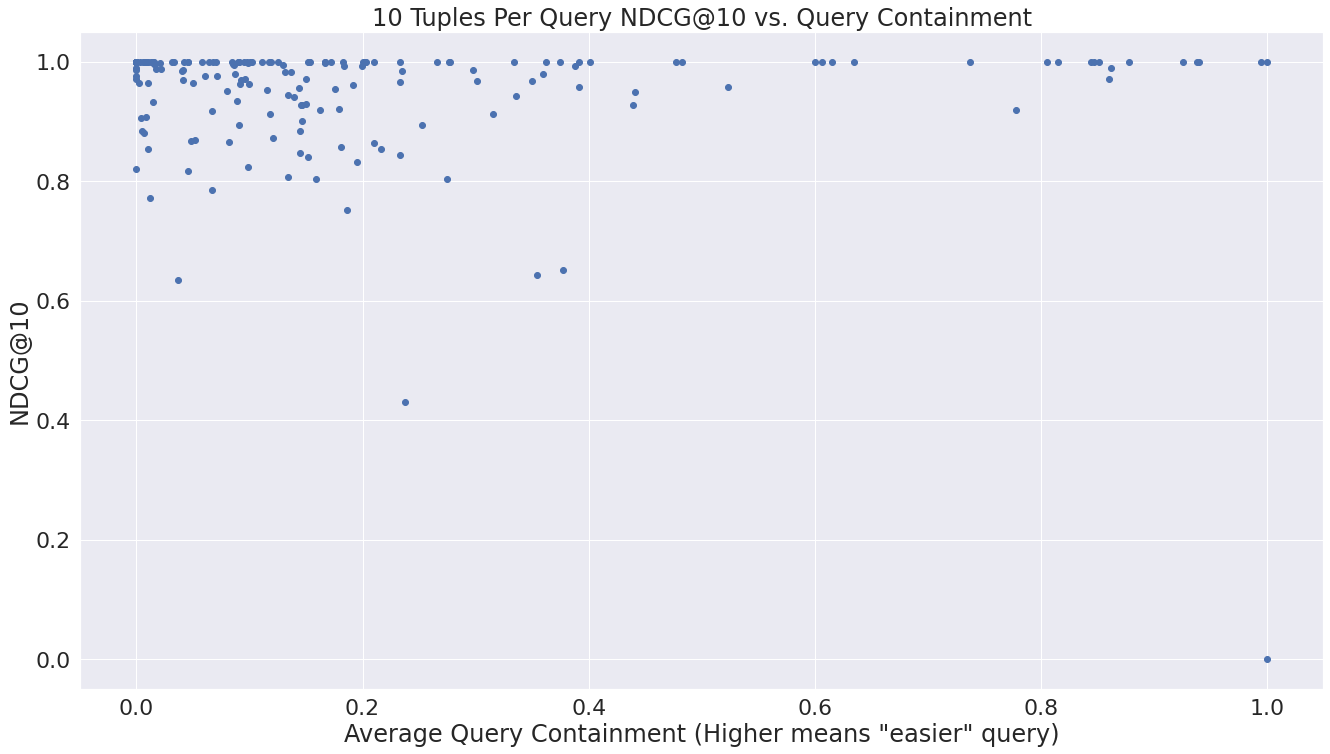

In [42]:
plt.scatter(dfs_dict[10]['entities']['content_jaccard']['avg_query_containment'], dfs_dict[10]['entities']['content_jaccard']['ndcg@10'])
plt.xlabel('Average Query Containment (Higher means "easier" query)');plt.ylabel('NDCG@10');plt.title('10 Tuples Per Query NDCG@10 vs. Query Containment');plt.tight_layout()
plt.savefig('figures/wikipage_categories/BM25_entity_queries_jaccard_ndcg10_vs_query_containment.svg')

In [43]:
queries_path = '../../Web-Table-Retrieval-Benchmark/data/wikipages/queries/minTupleWidth_2_tuplesPerQuery_10/entities/queries.txt'
scores_path = '../../Web-Table-Retrieval-Benchmark/data/wikipages/ranking/minTupleWidth_2_tuplesPerQuery_10/entities/content.txt'
groundtruth_relevance_scores_dir='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/weighted/'
tables_dir = '../../data/tables/wikipages/tables/'

# Maps each wikipage_id to its respective keyword query
queries_dict = get_bm25_keyword_queries(queries_path)

# Dataframe containing the top-100 tables from BM25 from each query
scores_df = pd.read_csv(scores_path, sep="\t", index_col=False, names=["wikipage_id", "query", "table_id", "rank", "score", "field"])

### Bottom-Right Corner (Easy Query & low NDCG score)

In [44]:
cur_df = dfs_dict[10]['entities']['content_jaccard']
cur_df = cur_df[(cur_df['ndcg@10'] == 0.0) & (cur_df['avg_query_containment'] >= 0.9)]
wikipage_id = cur_df.iloc[0]['wikipage_id']
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@5,ndcg@10,ndcg@15,ndcg@20,ndcg@50,ndcg@100
179587,https://en.wikipedia.org/wiki/List_of_England_...,179587,10,"[table-1228-884.json, table-1228-885.json, tab...","[40, 43, 24, 13, 23, 28, 33, 34, 33, 32]",2.0,10.0,table-1228-888.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",1.0,0.0,0.0,0.0,0.0,0.248042,0.380733


In [45]:
print("Selected wikipage:", cur_df.iloc[0]['wikipage'], '\n')
get_exploration_summary_bm25(wikipage_id, queries_dict, scores_df, tables_dir, groundtruth_relevance_scores_dir, k=10)

Selected wikipage: https://en.wikipedia.org/wiki/List_of_England_Test_matches 

Query:
 Oval national Melbourne Cricket Ground team The Australia cricket Sydney

Wikipage titles of top scored tables:
 ['List of Australia national rugby union team test match results', 'List of Australia national rugby union team test match results', 'List of results of the Australian national rugby league team', 'List of New Zealand rugby union Test matches', 'List of results of the Australian national rugby league team', 'List of New Zealand rugby union Test matches', 'List of results of the Australian national rugby league team', 'List of Australia national rugby union team test match results', 'List of New Zealand rugby union Test matches', 'List of results of the Australian national rugby league team']

Groundtruth Wikipages relevance scores:
 {'List_of_England_Test_matches': 1}


### Top-Left Corner (Hard Query & High NDCG score)

In [58]:
cur_df = dfs_dict[10]['entities']['content_jaccard']
cur_df = cur_df[(cur_df['ndcg@10'] == 1.0) & (cur_df['avg_query_containment'] == 0.0)]
wikipage_id = cur_df.iloc[7]['wikipage_id']
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@5,ndcg@10,ndcg@15,ndcg@20,ndcg@50,ndcg@100
344,https://en.wikipedia.org/wiki/List_of_vaudevil...,344,10,"[table-0002-885.json, table-0002-886.json, tab...","[53, 32, 105, 66, 50, 18, 41, 44, 61, 11]",2.0,10.0,table-0002-887.json,"[3, 7, 9, 13, 14, 15, 18, 20, 21, 22]",0.0,1.0,1.0,1.000000,1.000000,1.000000,0.896189
11245,https://en.wikipedia.org/wiki/List_of_Geelong_...,11245,15,"[table-0078-726.json, table-0078-727.json, tab...","[22, 62, 72, 71, 50, 27, 13, 49, 30, 40, 26, 2...",2.0,10.0,table-0078-728.json,"[2, 3, 4, 7, 8, 9, 10, 12, 13, 14]",0.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000
87013,https://en.wikipedia.org/wiki/List_of_Football...,87013,11,"[table-0586-799.json, table-0586-800.json, tab...","[153, 25, 22, 21, 26, 27, 24, 62, 24, 26, 22]",3.0,10.0,table-0586-799.json,"[0, 1, 2, 3, 4, 6, 8, 10, 11, 12]",0.0,1.0,1.0,1.000000,1.000000,0.650943,0.561157
91795,https://en.wikipedia.org/wiki/List_of_cities_w...,91795,14,"[table-0618-587.json, table-0618-589.json, tab...","[50, 11, 12, 40, 11, 18, 34, 11, 57, 21, 13, 1...",2.0,10.0,table-0618-606.json,"[0, 2, 8, 9, 12, 13, 17, 19, 20, 23]",0.0,1.0,1.0,1.000000,1.000000,0.721787,0.721787
97391,https://en.wikipedia.org/wiki/List_of_best-sel...,97391,10,"[table-0657-509.json, table-0657-510.json, tab...","[40, 20, 29, 45, 30, 83, 10, 44, 38, 14]",2.0,10.0,table-0657-519.json,"[0, 3, 4, 5, 6, 8, 9, 10, 12, 16]",0.0,1.0,1.0,1.000000,1.000000,0.721787,0.721787
140677,https://en.wikipedia.org/wiki/List_of_universi...,140677,14,"[table-0961-273.json, table-0961-274.json, tab...","[20, 89, 77, 19, 12, 16, 38, 10, 83, 39, 17, 8...",2.0,10.0,table-0961-274.json,"[3, 4, 5, 7, 8, 9, 10, 11, 12, 13]",0.0,1.0,1.0,1.000000,1.000000,0.735777,0.556351
154023,https://en.wikipedia.org/wiki/List_of_former_n...,154023,13,"[table-1051-953.json, table-1051-954.json, tab...","[49, 62, 13, 38, 29, 76, 27, 58, 44, 38, 72, 5...",3.0,10.0,table-1051-959.json,"[0, 1, 2, 5, 7, 8, 9, 10, 11, 12]",0.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000
164705,https://en.wikipedia.org/wiki/List_of_urban_ra...,164705,10,"[table-1121-54.json, table-1121-62.json, table...","[27, 12, 37, 22, 15, 44, 21, 17, 17, 10]",2.0,10.0,table-1121-80.json,"[8, 12, 14, 15, 16, 17, 18, 19, 20, 26]",0.0,1.0,1.0,0.984948,0.984948,0.984948,0.956490
170297,https://en.wikipedia.org/wiki/Regional_Trial_C...,170297,14,"[table-1163-298.json, table-1163-299.json, tab...","[13, 30, 23, 25, 25, 19, 11, 33, 27, 27, 47, 2...",2.0,10.0,table-1163-308.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000
173324,https://en.wikipedia.org/wiki/List_of_Universi...,173324,17,"[table-1186-510.json, table-1186-512.json, tab...","[18, 154, 34, 12, 20, 53, 17, 49, 15, 11, 63, ...",2.0,10.0,table-1186-512.json,"[0, 1, 2, 3, 4, 6, 7, 9, 10, 11]",0.0,1.0,1.0,1.000000,1.000000,1.000000,0.713523


In [59]:
print("Selected wikipage:", cur_df.iloc[7]['wikipage'], '\n')
get_exploration_summary_bm25(wikipage_id, queries_dict, scores_df, tables_dir, groundtruth_relevance_scores_dir, k=10)

Selected wikipage: https://en.wikipedia.org/wiki/List_of_urban_rail_systems_in_Japan 

Query:
 Oshiage Keisei Railway Corporation Kanamachi Chihara Airport Sagami Electric Keio Main Higashi-Narita Narita Inokashira Line Chiba Sagamihara

Wikipage titles of top scored tables:
 ['List of urban rail systems in Japan', 'List of urban rail systems in Japan', 'List of urban rail systems in Japan', 'List of urban rail systems in Japan', 'List of urban rail systems in Japan', 'List of urban rail systems in Japan', 'List of urban rail systems in Japan', "World's busiest airports by cargo traffic", "World's busiest airports by cargo traffic", "World's busiest airports by cargo traffic"]

Groundtruth Wikipages relevance scores:
 {'List_of_urban_rail_systems_in_Japan': 1.0}


### List_of_minor_planets:_211001–212000

In [72]:
wikipage_id = 85987
cur_df = dfs_dict[10]['entities']['content_jaccard']
cur_df = cur_df[cur_df['wikipage_id'] == wikipage_id]
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@5,ndcg@10,ndcg@15,ndcg@20,ndcg@50,ndcg@100
85987,https://en.wikipedia.org/wiki/List_of_minor_pl...,85987,10,"[table-0579-485.json, table-0579-486.json, tab...","[17, 24, 20, 15, 15, 17, 22, 28, 18, 18]",2.0,10.0,table-0579-490.json,"[0, 1, 2, 5, 7, 10, 11, 12, 13, 15]",0.925926,1.0,1.0,1.0,1.0,1.0,0.999414


In [73]:
get_exploration_summary_bm25(wikipage_id, queries_dict, scores_df, tables_dir, groundtruth_relevance_scores_dir, k=10)

Query:
 Kitt Search Near-Earth-Object Lemmon Mesa Station Anderson Peak Spacewatch Observatory Lowell Mount Survey National

Wikipage titles of top scored tables:
 ['List of minor planets: 207001–208000', 'List of minor planets: 212001–213000', 'List of minor planets: 209001–210000', 'List of minor planets: 199001–200000', 'List of minor planets: 204001–205000', 'List of minor planets: 212001–213000', 'List of minor planets: 199001–200000', 'List of minor planets: 199001–200000', 'List of minor planets: 207001–208000', 'List of minor planets: 212001–213000']

Groundtruth Wikipages relevance scores:
 {'List_of_minor_planets:_211001–212000': 1.0, 'List_of_minor_planets:_212001–213000': 1.0, 'List_of_minor_planets:_209001–210000': 1.0, 'List_of_minor_planets:_208001–209000': 1.0, 'List_of_minor_planets:_207001–208000': 1.0, 'List_of_minor_planets:_206001–207000': 1.0, 'List_of_minor_planets:_204001–205000': 1.0, 'List_of_minor_planets:_202001–203000': 1.0, 'List_of_minor_planets:_201001–2

### List_of_public-access_TV_stations_in_the_United_States_(Nebraska-Pennsylvania)

In [68]:
wikipage_id=140474
cur_df = dfs_dict[10]['entities']['content_jaccard']
cur_df = cur_df[cur_df['wikipage_id'] == wikipage_id]
cur_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,avg_query_containment,ndcg@5,ndcg@10,ndcg@15,ndcg@20,ndcg@50,ndcg@100
140474,https://en.wikipedia.org/wiki/List_of_public-a...,140474,11,"[table-0959-821.json, table-0959-822.json, tab...","[10, 21, 38, 56, 47, 163, 11, 101, 51, 18, 93]",2.0,10.0,table-0959-827.json,"[0, 1, 2, 5, 6, 13, 15, 17, 21, 26]",0.0,1.0,0.975788,0.975788,0.975788,0.92827,0.888216


In [69]:
get_exploration_summary_bm25(wikipage_id, queries_dict, scores_df, tables_dir, groundtruth_relevance_scores_dir, k=10)

Query:
 Bridgewater-Raritan Grove, Institute City College Bergen, Bergen District Hill, Edison, of Matawan-Aberdeen School Hill Aberdeen Camden, Bayville, Gloucester Bridgewater Township, Central Burlington Jersey County, Schools Community High Rancocas Technology County Camden Grove Township Public Cedar Cherry Edison New Regional Valley

Wikipage titles of top scored tables:
 ['List of public-access TV stations in the United States (Nebraska-Pennsylvania)', 'List of public-access TV stations in the United States (Nebraska-Pennsylvania)', 'List of public-access TV stations in the United States (Nebraska-Pennsylvania)', 'List of public-access TV stations in the United States (Nebraska-Pennsylvania)', 'List of Missouri high schools by athletic conferences', 'List of university and college name changes in the United States', 'List of university and college name changes in the United States', 'List of public-access TV stations in the United States (Nebraska-Pennsylvania)', 'List of bus tr

In [76]:
wikipage_id=97391
cur_df = dfs_dict[10]['entities']['content_jaccard']
cur_df = cur_df[cur_df['wikipage_id'] == wikipage_id]
get_exploration_summary_bm25(wikipage_id, queries_dict, scores_df, tables_dir, groundtruth_relevance_scores_dir, k=10)

Query:
 You and Brown Guess Sebring Influence Steinbeck Lowrey Wrath Mitch Earth Grapes Goodnight with Are I Sendak of Little Morrie Janette John Pillars Moon Puppy Ken How Margaret Shack Albom Win Friends Michael Young Carnegie McBratney The Love Tuesdays People Wild to Poky Story Ende Sam William Much Follett Where Maurice P. Wise Dale Things Neverending the

Wikipage titles of top scored tables:
 ['List of best-selling books', 'List of number-one singles in Australia during the 1950s', '2013 in American music', 'Academy Award for Best Writing (Adapted Screenplay)', 'List of Conan episodes (2012)', '2013 in American music', 'List of university mottos', 'Academy Award for Best Writing (Adapted Screenplay)', 'List of The Transformers characters', 'List of The Transformers characters']

Groundtruth Wikipages relevance scores:
 {'List_of_best-selling_books': 1.0, 'Kono_Mystery_ga_Sugoi!': 0.18437474194517264}


# Testing

In [195]:
true_relevance = np.asarray([[1, 1, 1, 1, 1, 1, 1]])
scores = np.asarray([[4, 3, 2, 1.5, 1, 0.99, 0.8]])
ndcg_score(true_relevance, scores, k=3)

1.0

In [192]:
true_relevance = np.asarray([[1, 1, 0.5]])
scores = np.asarray([[4, 3, 2]])
ndcg_score(true_relevance, scores, k=3)

1.0